In [1]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 2.4MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=b990a6fdf65010d1d28b6d4536b1ea66e3450b5180343462439a142e34fe7f9b
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=52f0f006a1f65dde95ecbc8eced35144622edd4c3b98137e4a6646f6ef0a77c0
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=f7896c92756bd913d81c0873f9e423ae0122d84ba0e22513b27b7d37935a4c7b
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.1MB 4.9MB/s 


### IMPORT

In [38]:
import pandas as pd
import numpy as np
try:
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
from google.colab import drive
import tensorflow_hub as hub
import re
from tensorflow.keras import layers
import bert
import random
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
import pickle
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
data =pickle.load(open('/content/drive/My Drive/NewsClassifier/News_data_with_length','rb'))
data.head()

,category,headline,authors,short_description,headline_length,short_description_length,information,info_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...,14,13,There Were 2 Mass Shootings In Texas Last Week...,27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.,14,6,Will Smith Joins Diplo And Nicky Jam For The 2...,20
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Ebe...,10,15,Hugh Grant Marries For The First Time At Age 5...,25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,The actor gives Dems an ass-kicking for not fi...,11,14,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,25
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,"The ""Dietland"" actress said using the bags is ...",13,13,Julianna Margulies Uses Donald Trump Poop Bags...,26


In [6]:
data = data[['category','information']]
data.head()

,category,information
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [0]:
def clean_text(text):
  text = re.sub(r"@[A-Za-z0-9]+"," ",text) # remove @usernames
  text = re.sub(r"https?://[A-Za-z0-9./]+"," ",text) #remove https links
  text = re.sub(r"[^A-Za-z.!?']"," ",text)  # keep only letters and few punctuations
  text = re.sub(r" +"," ",text) # remove extra spaces
  text = text.lower()
  return text

In [0]:
def remove_stop(msg):
    nopunc = msg.split()
    clean = [word for word in nopunc if word.lower() not in stopwords.words('english')]
    clean = " ".join(clean)
    return clean

In [0]:
data['processed_info'] = data.information.apply(clean_text)

In [0]:
data['processed_info'] = data.processed_info.apply(remove_stop)

In [0]:
X,y = data.processed_info.values, data.category.values

In [0]:
pickle.dump((X,y),open('/content/drive/My Drive/NewsClassifier/stop_removed_info_and_label','wb'))

#### USING BERT TOKENIZER

In [0]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [0]:
tag2idx ={}
c=0
for tag in set(y):
    tag2idx[tag] = c
    c+=1
idx2tag = { v:k for k,v in tag2idx.items()}

In [0]:
 data_X = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)) for sentence in X]
 data_y = [tag2idx[tag] for tag in y]

### SPLITTING OF SKEWED DATA

In [31]:
skf = StratifiedShuffleSplit(n_splits=2,test_size=0.2)
skf.get_n_splits(data_X,data_y )

2

In [0]:
X_array = np.array(data_X)
y_array = np.array(data_y)

In [33]:
for train_index,test_index in skf.split(data_X,data_y):   ## Splitting into train and test_set
  print("TRAIN:", train_index, "TEST:", test_index)
  #print(len(train_index))
  X_train,X_test = X_array[train_index], X_array[test_index]
  y_train,y_test = y_array[train_index], y_array[test_index]


TRAIN: [ 25554 117917  74331 ... 137691  59444  67457] TEST: [ 89923 184310  43149 ...  79045 103158  10760]
TRAIN: [ 16294  56962  80183 ... 116962  17369  65464] TEST: [163509 130570  84725 ...  67981 129595  50104]


###### PADDING the entire data and truncating to length 20

In [0]:
X_train =tf.keras.preprocessing.sequence.pad_sequences(
    X_train, maxlen=20, dtype='int32', padding='pre', truncating='pre',
    value=0.0
)
X_test =tf.keras.preprocessing.sequence.pad_sequences(
    X_test, maxlen=20, dtype='int32', padding='pre', truncating='pre',
    value=0.0
)

In [35]:
print(X_train.shape)
print(X_test.shape)

(157112, 20)
(39278, 20)


In [36]:
from sklearn.model_selection import train_test_split  ### Splitting into test and cross_validation set
X_val, X_test, y_val, y_test = train_test_split(
     X_test, y_test, test_size=0.5, random_state=42)
print(X_val.shape)
print(X_test.shape)

(19639, 20)
(19639, 20)


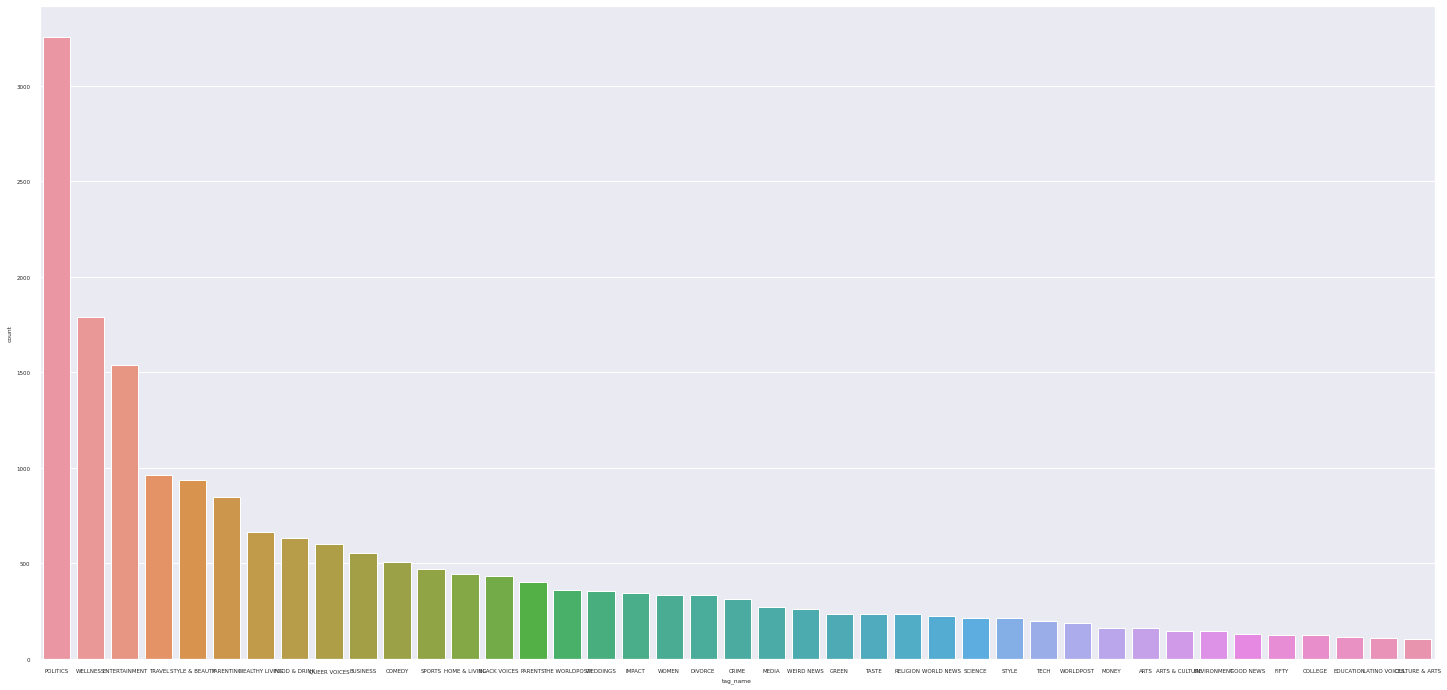

In [40]:
df = pd.DataFrame(y_test,columns=['targets'])             
index = pd.DataFrame(df.targets.value_counts().index)
counts = pd.DataFrame(df.targets.value_counts().values)
concat_df = pd.concat([index,counts],axis=1)
concat_df.columns =['tag','count']
# concat_df.head(2)
labels = [idx2tag[idx] for idx in index]
def get_names(x):
  return idx2tag[x]
concat_df['tag_name'] = concat_df.tag.apply(get_names)
plt.figure(figsize=(25,12))
sns.set(font_scale=0.5)
sns.barplot(x="tag_name",y="count",data=concat_df)       ### Distribution of classes in Training set

### MODEL 

In [0]:
V = len(tokenizer.vocab)
model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(V, 64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')
])


#### Checkpoints

In [42]:
checkpoint_directory = "/content/drive/My Drive/NewsClassifier/LSTM/ckpts"
checkpoint = tf.train.Checkpoint(model=model) 
manager = tf.train.CheckpointManager(checkpoint,checkpoint_directory,max_to_keep=1)
if manager.latest_checkpoint:
  checkpoint.restore(manager.latest_checkpoint) #Restores this Checkpoint and any objects it depends on.
  print("Latest Checkpoint restored!! ") 

Latest Checkpoint restored!! 


### Train

In [43]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
num_epochs = 10
history = model.fit(X_train,y_train, epochs=num_epochs, verbose=2,batch_size=32,validation_data=(X_val,y_val))
manager.save()

Epoch 1/10
4910/4910 - 96s - loss: 1.8145 - sparse_categorical_accuracy: 0.5325 - val_loss: 1.4225 - val_sparse_categorical_accuracy: 0.6140
Epoch 2/10
4910/4910 - 94s - loss: 1.4851 - sparse_categorical_accuracy: 0.5973 - val_loss: 1.4014 - val_sparse_categorical_accuracy: 0.6147
Epoch 3/10
4910/4910 - 92s - loss: 1.3798 - sparse_categorical_accuracy: 0.6204 - val_loss: 1.4118 - val_sparse_categorical_accuracy: 0.6156
Epoch 4/10
4910/4910 - 92s - loss: 1.3072 - sparse_categorical_accuracy: 0.6371 - val_loss: 1.4342 - val_sparse_categorical_accuracy: 0.6120
Epoch 5/10
4910/4910 - 93s - loss: 1.2512 - sparse_categorical_accuracy: 0.6511 - val_loss: 1.4480 - val_sparse_categorical_accuracy: 0.6120
Epoch 6/10
4910/4910 - 91s - loss: 1.2044 - sparse_categorical_accuracy: 0.6617 - val_loss: 1.4619 - val_sparse_categorical_accuracy: 0.6089
Epoch 7/10
4910/4910 - 93s - loss: 1.1693 - sparse_categorical_accuracy: 0.6687 - val_loss: 1.4892 - val_sparse_categorical_accuracy: 0.6078
Epoch 8/10
49

'/content/drive/My Drive/NewsClassifier/LSTM/ckpts/ckpt-2'

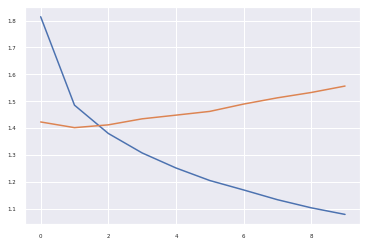

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

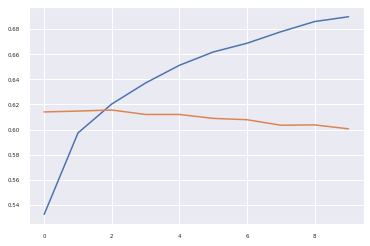

In [45]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

In [46]:
results = model.evaluate(X_test,y_test)
print(results)

614/614 [==============================] - 2s 3ms/step - loss: 1.5624 - sparse_categorical_accuracy: 0.5941
[1.562388300895691, 0.5940729975700378]
